In [3]:
import gzip, pickle
from scipy import stats
import numpy as np


def load_data(fn):
    with gzip.open(fn) as f:
        d = pickle.load(f)
    return d

def save_data(d, fn):
    with gzip.open(fn, "w") as f:
        pickle.dump(d, f)

G_f_src = "TEST.pkl.gz"
G_f_tar = "AE1_in.pkl.gz"

G_hist_raw = load_data(G_f_src)
print(len(G_hist_raw))

171


In [4]:
def x_ae_col_1(col_1):
    
    l = len(col_1)
    
    #get ratio
    col_new = list()
    for i in range(l-1):
        x1 = col_1[i]
        x2 = col_1[i+1]

        r = (x2*1.0)/(x1+x2)
        if (r != r):
            r = 0.5
        col_new.append(r)

    return stats.zscore(col_new)


def x_ae_1(hist_1):
    
    if (len(hist_1)<26):
        return list()
    
    # column-wise processing r=(today/(today+yesterday))
    norm = list()
    for col in hist_1.columns:
        norm.append(x_ae_col_1(hist_1[col]))

    norm_T = np.transpose(norm)

    # flatten 20 lines
    l = len(norm_T)
    x_1 = list()
    for i in range(l-24):
        x_1.append(norm_T[i:i+20].flatten())
    
    return x_1


def k_ae_1(c, hist_1):
    return [(c, i) for i in hist_1.index[20:-5] ]


def y_ae_1(hist_1):
    y_1 = list()
    y_raw = hist_1["Adj Close"]
    l = len(y_raw)
    for i in range(l-25):
        y_new = y_raw[i+24] / (y_raw[i+24] + y_raw[i+20])
        if (y_new != y_new):
            y_new = 0
        else:
            y_new = int((y_new-0.52)/100.0+1.0) # 1 if y_new>0.52
            
        y_1.append(y_new)
        
    return y_1



def kxy_ae(hist_all):
    
    #check blank
    max_len = 0
    for c in hist_all.keys():
        k_1 = k_ae_1(c, hist_all[c])
        if (max_len < len(k_1)):
            max_len = len(k_1)
    
    x_all, y_all, k_all = list(), list(), list()
    for c in hist_all.keys():
        k_1 = k_ae_1(c, hist_all[c])
        if (max_len == len(k_1)):
            k_all.extend(k_1)
            x_all.extend(x_ae_1(hist_all[c]))
            y_all.extend(y_ae_1(hist_all[c]))

    return (k_all, x_all, y_all)

In [5]:
G_data_ae = kxy_ae(G_hist_raw)

print(len(G_data_ae[0]), len(G_data_ae[1]), len(G_data_ae[2]))
print(sum(G_data_ae[2])/len(G_data_ae[2]))

save_data(G_data_ae, G_f_tar)

/home/wooyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


265907 265907 265907
0.04347760683246398


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gzip, pickle
import copy, math


G_f_src = "AE1_in.pkl.gz"
G_f_tar = "AE1_out.pkl.gz"

def load_data(fn):
    with gzip.open(fn) as f:
        return pickle.load(f)
    
def save_data(d, fn):
    with gzip.open(fn, "w") as f:
        pickle.dump(d, f)


(G_k, G_x, G_y) = load_data(G_f_src)

data_tr = copy.deepcopy(G_x)

np.random.shuffle(data_tr)
data_te = copy.deepcopy(data_tr[0:512])

In [7]:
n = len(G_x)
num_input = len(G_x[0])
print ("dim = (%d, %d)" % (num_input, n))


# Training Parameters
learn_rate = 0.002
num_epoch  = 25
batch_size = 64
num_batch  = int (n / batch_size)

# Network Parameters
num_hidden_1 = int(num_input * 2.1 / 3.1) # 1st layer num features
num_hidden_2 = int(num_input * 2.6 / 9.6) # 2nd layer num features (the latent dim)

print ("Nodes: %d -> %d -> %d" % (num_input,num_hidden_1,num_hidden_2))

dim = (120, 265907)
Nodes: 120 -> 81 -> 32


In [8]:
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, num_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

# Building the encoder
def normalize(x):
    x_norm = tf.nn.sigmoid(x)
    return x_norm

def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    return layer_2


# Building the decoder
def decoder(x):
    # Decoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    return layer_2

# Construct model
X_norm     = normalize(X)
encoder_op = encoder(X_norm)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X_norm

# Define loss and optimizer, minimize the squared error
loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learn_rate).minimize(loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [9]:
# Start Training
# Start a new TF session
with tf.Session() as sess:
    
    # Run the initializer
    sess.run(init)
    after_l = list()

    epoch_loss = sess.run(loss, feed_dict={X: G_x})
    print('Starting Loss: %f' % (epoch_loss))
    
    # Training
    for epoch in range(1, num_epoch+1):
        
        np.random.shuffle(data_tr)
        
        for i in range(num_batch):
            batch_x = data_tr[i*batch_size:(i+1)*batch_size]
           
            # Run optimization op (backprop) and cost op (to get loss value)
            _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
            
            steps = (epoch-1) * num_batch + i
            #if (int(math.sqrt(epoch))**2 == epoch) or (epoch == num_epoch):
            if (((int(math.sqrt(steps / 100.0))**2)*100)==steps):
                before, after, l = sess.run([X_norm, decoder_op, loss], feed_dict={X: data_te})
                print('Epoch %i: Testing Loss: %f' % (epoch, l))
                after_l.append(after)

        print('Epoch %i: Minibatch Loss: %f' % (epoch, l))

    G_x_enc, epoch_loss = sess.run([encoder_op, loss], feed_dict={X: G_x})
    print('Final Loss: %f' % (epoch_loss))

Starting Loss: 0.237396
Epoch 1: Testing Loss: 0.235053
Epoch 1: Testing Loss: 0.048961
Epoch 1: Testing Loss: 0.037234
Epoch 1: Testing Loss: 0.035638
Epoch 1: Testing Loss: 0.031047
Epoch 1: Testing Loss: 0.027411
Epoch 1: Testing Loss: 0.023159
Epoch 1: Minibatch Loss: 0.021063
Epoch 2: Testing Loss: 0.020898
Epoch 2: Testing Loss: 0.019694
Epoch 2: Testing Loss: 0.018069
Epoch 2: Minibatch Loss: 0.018804
Epoch 3: Testing Loss: 0.016243
Epoch 3: Testing Loss: 0.014984
Epoch 3: Minibatch Loss: 0.014873
Epoch 4: Testing Loss: 0.013649
Epoch 4: Minibatch Loss: 0.012298
Epoch 5: Testing Loss: 0.012690
Epoch 5: Testing Loss: 0.012063
Epoch 5: Minibatch Loss: 0.013136
Epoch 6: Testing Loss: 0.011258
Epoch 6: Minibatch Loss: 0.010370
Epoch 7: Testing Loss: 0.010605
Epoch 7: Testing Loss: 0.009612
Epoch 7: Minibatch Loss: 0.009745
Epoch 8: Testing Loss: 0.008798
Epoch 8: Minibatch Loss: 0.008186
Epoch 9: Testing Loss: 0.008532
Epoch 9: Minibatch Loss: 0.008437
Epoch 10: Testing Loss: 0.0083

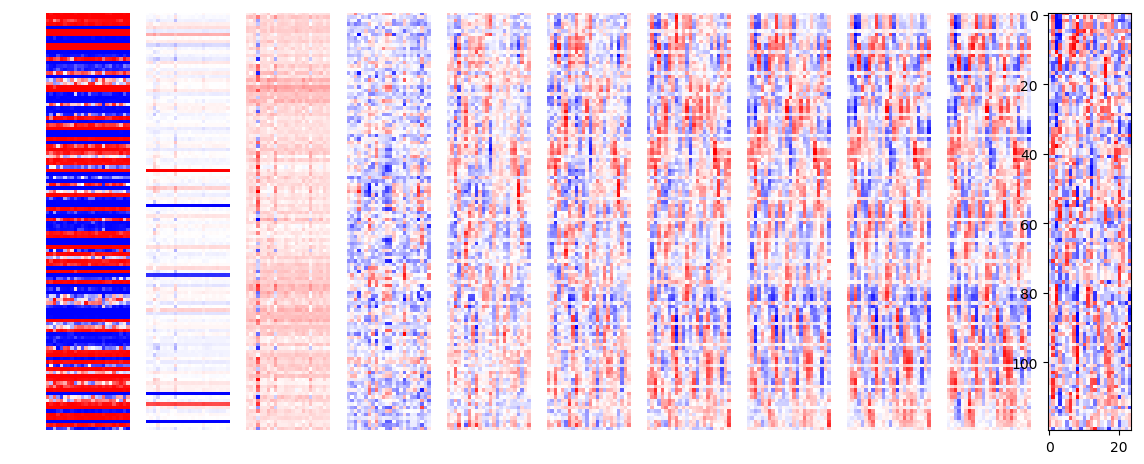

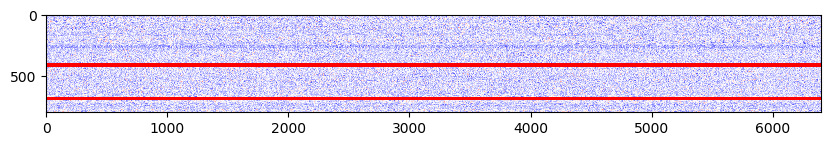

Normalization dim = (265907, 32) -> (265907, 27)


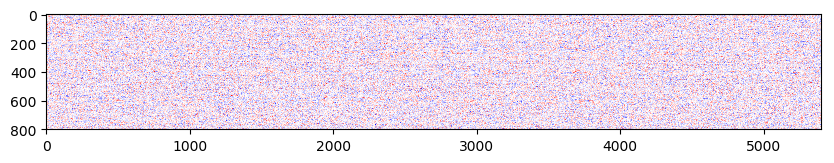

In [10]:
n_after = 10 #len(after_l)
fig = plt.figure(figsize=(n_after+4,20), dpi=100)
for i in range(n_after):
    a = fig.add_subplot(1, n_after+1, i+1)
    plt.imshow(after_l[i][:24].T, origin="upper", cmap="bwr")
    plt.axis('off')

a = fig.add_subplot(1, n_after+1, n_after+1)
plt.imshow(before[:24].T, origin="upper", cmap="bwr")
plt.axis('on')
plt.show()


# In[9]:


plt.figure(figsize=(10,3), dpi=100)
plt.imshow(G_x_enc[:160000].T.reshape(800,-1), origin="upper", cmap="bwr")
plt.show()


# In[14]:


from scipy import stats

def normalize_enc(enc):
    enc_T = np.transpose(enc)
    enc_T_new = list()
    
    for T in enc_T:
        T_new = stats.zscore(T)
        for i in range(len(T_new)):
            if (T_new[i] > 5.0):
                T_new[i] = 5.0
            elif (T_new[i] < -5.0):
                T_new[i] = -5.0
                
        T_new_sum = sum(T_new)
        #print(T_new_sum)
        if (T_new_sum < 1.0) and (T_new_sum > -1.0):
            enc_T_new.append(T_new)
            
    return np.transpose(enc_T_new)


# In[15]:


G_x_norm = normalize_enc(G_x_enc)
print ("Normalization dim = (%d, %d) -> (%d, %d)" % (len(G_x_enc), len(G_x_enc[0]), len(G_x_norm), len(G_x_norm[0])))


# In[16]:


G_data_ae2 = (G_k, G_x_norm, G_y)
save_data(G_data_ae2, G_f_tar)


# In[17]:


plt.figure(figsize=(10,3), dpi=100)
plt.imshow(G_x_norm[:160000].T.reshape(800,-1), origin="upper", cmap="bwr")
plt.show()